## Sine Wave

To illustrate a basic usage pattern, sequential observations from the sine wave function will be modelled by the reservoir. The first step will be to create the sine wave data for our example.

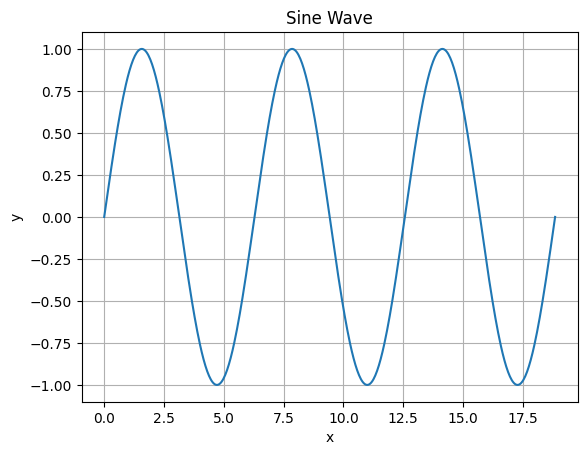

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x-values for the domain of the sine function input
x = np.linspace(0, 6 * np.pi, 500)
# Calculate the y-values using the sine function and probability function
y = np.sin(x)

# Plot the oscillator with probability-based amplitudes
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine Wave')
plt.grid(True)
plt.show()

In the below code block make sure to replace both IP_ADDR and PORT with your specific network location for your EmuCore device

In [2]:
from emucore_direct.client import EmuCoreClient
from time import time

IP_ADDR = "YOUR DEVICE IP ADDRESS"
PORT = "YOUR DEVICE PORT"
# Instantiate an EmuCore instance
ec_client = EmuCoreClient(ip_addr=IP_ADDR, port = PORT)

Reservoir systems require state while processing so in order to prevent collisions a locking mechanism on the device is available. To acquire the execution lock a user must run: 

In [3]:
lock_id, _, _ = ec_client.wait_for_lock()

This function waits for the execution lock indefinitely until it becomes available.

The basic recipe for modeling using EmuCore is to sequentially feed data to the reservoir. This process creates an expanded representation based on the current configuration of the reservoir model. Subsequently, a model is applied to the augmented data from the reservoir. This expanded representation should be easier to model and may require less complicated models to achieve good prediction results for a given series. Before running another dataset, it is important to reset the reservoir; otherwise, it will retain information from previous data that was modeled. Next, the reservoir model must be configured. There are a variety of parameters that can be tuned to obtain better results from predictions. Here is an example of a possible configuration:

In [4]:
vbias=0.3
gain=0.5
num_nodes=800
num_taps=400
input_scaling=0.33
density=0.5

ec_client.reservoir_reset(lock_id=lock_id)
print("Reservoir config")
# Configure
ec_client.rc_config(
    lock_id=lock_id,
    vbias=vbias,
    gain=gain,
    num_nodes=num_nodes,
    num_taps=num_taps,
)

Reservoir config


{'status': 0, 'message': ''}

Now we begin modeling the data with the reservoir: 

In [5]:
y_resp, max_scale_val, weights = ec_client.process_all_data(
    input_data=y.reshape((-1,1)),
    num_nodes=num_nodes,
    density=density,
    feature_scaling=input_scaling,
    lock_id=lock_id,
    max_scale_val=None)

After processing it is important to release the device execution lock to free up the device for other usage:

In [6]:
# releasing lock after finished with device execution
ec_client.release_lock(lock_id=lock_id)

{'status': 0, 'message': 'Success'}

Below, the output of the reservoir is visualized, with the coloring representing the value for each combination of a given node and a given value in our sequence from the sine function. Since the sine function generates a repeating sequence, observe how the values across nodes repeat for this particular series due to the cyclic nature of the underlying function. However, with more complex inputs, this representation can become much more varied.

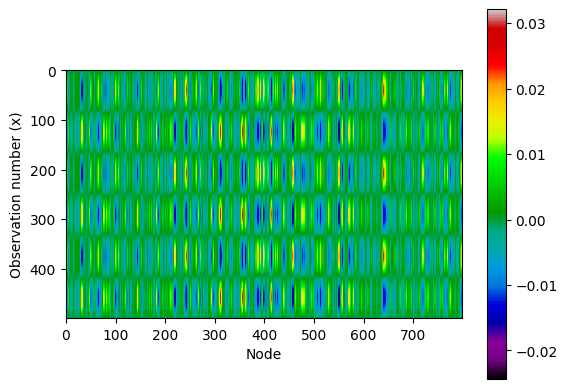

In [7]:
plt.imshow(y_resp, cmap="nipy_spectral")
plt.colorbar() 
plt.xlabel("Node")
plt.ylabel("Observation number (x)")
plt.show()

Having acquired the data any number of models can be fit to predict future outcomes using the dynamics of the reservoir model.